In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BMonthEnd, BMonthBegin
import pyfolio as pf
import warnings
warnings.simplefilter('ignore')

# Aggressive Versions of Meb Faber’s GTAA Strategy

The Aggressive versions of Meb Faber's GTAA strategy, namely Agg 3 and Agg 6, employ both relative momentum (asset returns relative to other assets) and absolute momentum (asset returns relative to itself). These versions take concentrated positions in a diverse basket of global asset classes. The Agg 3 version holds 3 assets at any given time with 1/3 of the portfolio allocated to each, while the Agg 6 version holds 6 assets with 1/6 allocated to each.

### Asset Classes

The strategy involves the following asset classes:

- **US large-cap value (IWD)**
- **US large-cap momentum (MTUM)**
- **US small-cap value (IWN)**
- **US small-cap equities (IWM)**
- **International equities (EFA)**
- **Emerging market equities (EEM)**
- **Intermediate-term US Treasuries (IEF)**
- **International Treasuries (BWX)**
- **US corporate bonds (LQD)**
- **Long-term US Treasuries (TLT)**
- **Commodities (DBC)**
- **Gold (GLD)**
- **Real estate (VNQ)**

### Strategy Rules

#### 1. Calculation of Returns

On the last trading day of the month, calculate the returns for each asset class over the following periods:

- **1-month return**: $ r_{1} = \frac{p_0}{p_1} - 1 $
- **3-month return**: $ r_{3} = \frac{p_0}{p_3} - 1 $
- **6-month return**: $ r_{6} = \frac{p_0}{p_6} - 1 $
- **12-month return**: $ r_{12} = \frac{p_0}{p_{12}} - 1 $

where $ p_0 $ is today's price, $ p_1 $ is the price at the close of last month, $ p_3 $ is the price at the close of three months ago, and so on.

#### 2. Average Momentum Score

Calculate the average momentum score for each asset class:

$
\text{Momentum Score} = \frac{r_{1} + r_{3} + r_{6} + r_{12}}{4}
$

#### 3. Asset Selection

Rank the asset classes based on their momentum scores. Go long the 3 (or 6) asset classes with the highest average value (relative momentum), unless the asset will close below its 10-month moving average (absolute momentum). If the asset's price is below its 10-month moving average, allocate that portion of the portfolio to cash.

#### 4. Portfolio Allocation

Allocate the portfolio as follows:

- **Agg 3 Version**: Hold the top 3 asset classes, allocating 1/3 of the portfolio to each.
- **Agg 6 Version**: Hold the top 6 asset classes, allocating 1/6 of the portfolio to each.

#### 5. Rebalancing

Hold positions until the final trading day of the following month. Rebalance the entire portfolio monthly, regardless of whether there is a change in position.

### Commentary

These aggressive versions of the GTAA strategy can take more concentrated positions than the original GTAA 13 strategy. This can lead to higher performance when the strategy times the markets well but also increases the risk of significant loss. The Agg 3 version, being more concentrated, exhibits higher volatility but similar risk-adjusted metrics like Sharpe, Sortino, and UPI compared to the Agg 6 version.

### Calculation Notes

- The strategy replaces US small-cap momentum with IWM due to the lack of a suitable ETF.
- EEM and BWX are not included prior to 1989 and mid-2002, respectively, due to a lack of accurate historical data.



[*********************100%%**********************]  14 of 14 completed


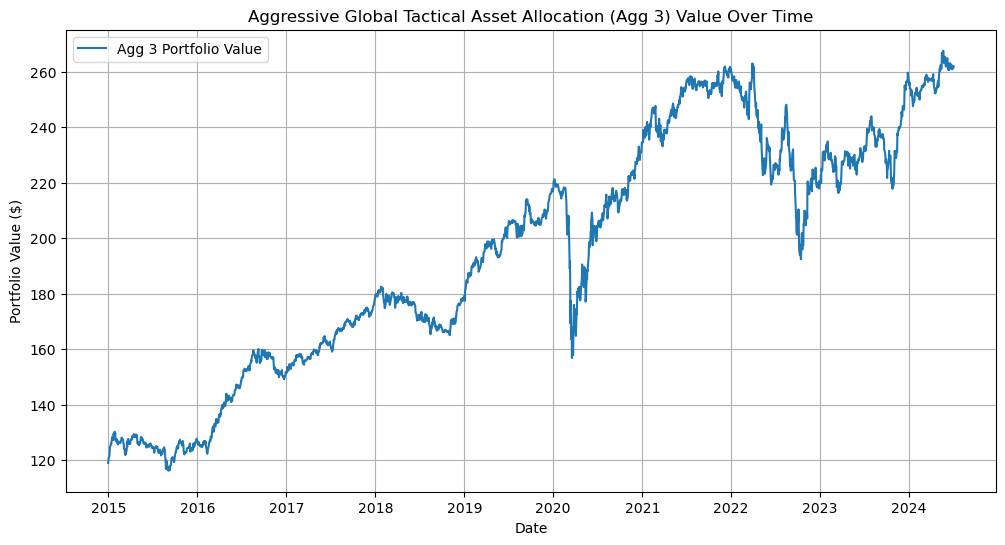

In [7]:
tickers = ['IWD', 'MTUM', 'IWN', 'IWM', 'EFA', 'EEM', 'IEF', 'BWX', 'LQD', 'TLT', 'DBC', 'GLD', 'VNQ', 'BIL']

start_date = '2014-01-01'
data = yf.download(tickers, start=start_date)['Adj Close']

moving_avg_200d = data.rolling(window=200).mean()
monthly_data = data.resample('BM').last()
monthly_returns = monthly_data.pct_change()

momentum_scores = (monthly_returns.rolling(window=1).mean() +
                   monthly_returns.rolling(window=3).mean() +
                   monthly_returns.rolling(window=6).mean() +
                   monthly_returns.rolling(window=12).mean()) / 4

allocations = pd.DataFrame(index=momentum_scores.index, columns=tickers).fillna(0)

for date in momentum_scores.index[1:]:
    if date not in data.index:
        continue
    
    top_assets = momentum_scores.loc[date].nlargest(3).index
    
    for asset in top_assets:
        if monthly_data.loc[date, asset] > moving_avg_200d.loc[date, asset]:
            allocations.loc[date, asset] = 1/3
        else:
            allocations.loc[date, 'BIL'] += 1/3

allocations.fillna(0, inplace=True)

daily_allocations = pd.DataFrame(index=data.index, columns=data.columns).fillna(0)
for date in allocations.index:
    try:
        next_day_idx = data.index.get_loc(date) + 1
        if next_day_idx < len(data.index):
            next_day = data.index[next_day_idx]
            daily_allocations.loc[next_day:] = allocations.loc[date].values
    except KeyError:
        pass

daily_allocations = daily_allocations.ffill()

daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='Agg 3 Portfolio Value')
plt.title('Aggressive Global Tactical Asset Allocation (Agg 3) Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)